# Discovering genes likely associated with the development of skin cutaneous melanoma

Documentation: 
- http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.variants_in_region
- http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.donor_distribution

Requirements to run this demo: https://github.com/tomalf2/data_summarization_1KGP/blob/master/demo/README_requirements

For this demo we took inspiration from the DiffMut technique developed at Singh-Lab (credits at the end) for differential analysis between somatic mutations and germline variation profiles. Considering a set of genes supposedly involved in a specific tumoral form, in our example the skin cutaneous melanoma, we are going to ask for each of them the variants located into the corresponding genomic area for healthy and non-healthy patients.

### Candidate genes

In [0]:
genes = ['CTSZ', 'EFEMP2', 'ITGA5', 'KDELR2', 'MDK', 'MICALL2', 'MAP2K3', 'PLAUR', 'SERPINE1', 'SOCS3']

Some utility functions

In [2]:
import requests
import json
import pandas as pd
import csv
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# make a request and check result
def post_request(to: str, argument, print_status_code=True, print_warnings=True, timeout=None):
    resp = requests.post(to, json=argument, timeout=timeout)
    if print_status_code:
        print(' response status code: {}'.format(resp.status_code))
    res_body = resp.json()
    if resp.status_code != 200:
        print(res_body)
    if print_warnings:
        print('warnings ?: {}'.format(res_body.get('notice')))
    return res_body



# call /variants_in_region and create a list of GENE_NAME + VARIANT
def get_variants_in_gene(genes, disease:str, in_cell_type:str) -> list:
    req_body = {
        'name': '!!!    WRITE HERE YOUR GENE NAME       !!!',  # gene name
        'of': {
            'assembly': 'grch38',
            'disease': disease,
            'having_variants': {
                'in_cell_type': [in_cell_type]
            }
        }
    }
    # make list of genes with their variants
    container = list()
    for gene in genes:
        req_body['name'] = gene     # set gene
        res = post_request('http://geco.deib.polimi.it/popstudy/api/variants_in_region', req_body, print_status_code=False, print_warnings=False)
        for variant in res['rows']:
            container.append([gene] + variant)  # gene, chrom, start, ref, alt
    return container




# call /donor_distribution and create a list with the number of donors for each of the input gene+variants
def get_donors_with_variant(gene_variants, disease:str, in_cell_type:str, to_csv:bool, filename:str):
    req_body = {
        "having_meta": {
            'assembly': 'grch38',
            'disease': disease
        },
        'having_variants': {
            'in_cell_type': [in_cell_type],
            'with': ['!!!       WRITE HERE YOUR VARIANT     !!!']
        },
        "distribute_by": ["health_status"]
    }
    # make list of variants with number of donors
    var_donors = list()
    for var in gene_variants:
        req_body['having_variants']['with'] = [{'chrom': var[1], 'start': var[2], 'ref': var[3], 'alt': var[4]}]
        res = post_request('http://geco.deib.polimi.it/popstudy/api/donor_distribution', req_body, print_status_code=False, print_warnings=False)
        donors = res['rows'][0][-1]    # N° donors
        var_donors.append(var + [donors])
    if to_csv:
        with open(filename, mode='w') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(['GENE', 'CHROM', 'START', 'REF', 'ALT', 'DONORS'])
            for row in var_donors:
                writer.writerow(row)
            csv_file.truncate()
    return var_donors

## To compare the mutation profile of each gene, we proceed with the following steps:
1. Assign to each gene G a score. The score is computed as the sum of (donors with variant A) for each variant A in gene G.
2. Rank normlaize the countings. This number represents the density of mutations and variants falling within each gene.
3. Compare the rank normalized scores to find the genes where the mutation and variation profiles differ the most between the tumor cohort and the healthy cohort.

### 1.a Gene scores in tumor cohort
    1.a.1 Request the somatic mutations falling into the genes of interest, from patients with skin cutaneous mealanoma

In [0]:
mutations_tumor_cohort = get_variants_in_gene(genes, disease='skin cutaneous melanoma', in_cell_type='somatic')

    1.a.2 Count the number of patients with skin cutaneous melanoma having each of those variants

In [0]:
# read from CSV - OR - uncomment the following lines
# donors_mutations_tumor_cohort = get_donors_with_variant(mutations_tumor_cohort, disease='skin cutaneous melanoma', in_cell_type='somatic', to_csv=True, filename='donors_mutations_tumor_cohort.csv')
# donors_mutations_tumor_cohort_df = pd.DataFrame.from_records(donors_mutations_tumor_cohort, columns=['GENE', 'CHROM', 'START', 'REF', 'ALT', 'DONORS'])

In [3]:
donors_mutations_tumor_cohort_df = pd.read_csv('donors_mutations_tumor_cohort.csv')
donors_mutations_tumor_cohort_df

,GENE,CHROM,START,REF,ALT,DONORS
0,CTSZ,20,58995684,G,A,1
1,CTSZ,20,58996631,A,G,1
2,EFEMP2,11,65867032,G,A,1
3,EFEMP2,11,65868358,G,A,1
4,EFEMP2,11,65868377,G,A,1
...,...,...,...,...,...,...
110,SOCS3,17,78358471,G,A,1
111,SOCS3,17,78358666,G,A,1
112,SOCS3,17,78358678,T,A,1
113,SOCS3,17,78358801,C,T,1


    1.a.3 Compute gene score

In [4]:
df2 = donors_mutations_tumor_cohort_df \
.groupby(['GENE'])['DONORS'].size().reset_index(name='SCORE') \
.sort_values('SCORE', ascending=False) \
.reset_index(drop=True)
df2

,GENE,SCORE
0,ITGA5,45
1,MICALL2,23
2,SERPINE1,11
3,PLAUR,9
4,EFEMP2,8
5,MAP2K3,7
6,SOCS3,5
7,KDELR2,4
8,CTSZ,2
9,MDK,1


### 2.a Rank normalize the gene score in tumor cohort

In [5]:
max_mut = df2['SCORE'][0]
df2['DENSITY'] = df2.apply(lambda r: r['SCORE']/max_mut, axis=1)

#  PLOT
#pd.pivot_table(df2.drop(['COUNT'], axis=1), index='GENE').plot(
#    kind='bar',
#    figsize=(6, 4),
#    legend=False
#)
#plt.title('Density of somatic mutations in patients with skin cutaneous melanoma')
#plt.ylabel('RANK NORMALIZED SCORE ')
#plt.show()

df2

,GENE,SCORE,DENSITY
0,ITGA5,45,1.000000
1,MICALL2,23,0.511111
2,SERPINE1,11,0.244444
3,PLAUR,9,0.200000
4,EFEMP2,8,0.177778
5,MAP2K3,7,0.155556
6,SOCS3,5,0.111111
7,KDELR2,4,0.088889
8,CTSZ,2,0.044444
9,MDK,1,0.022222


### 1.b Gene scores in healthy cohort
    1.b.1 variants from healty cohort falling into the candidate genes

In [0]:
# read from CSV - OR - uncomment the following lines
# variants_healthy_cohort = get_variants_in_gene(genes, disease='none', in_cell_type='germline')

    1.b.2 number of donors having the selected variants

In [ ]:
# donors_variants_healthy_cohort = get_donors_with_variant(variants_healthy_cohort, disease='none', in_cell_type='germline', to_csv=True, filename='donors_variants_healthy_cohort.csv')
# donors_variants_healthy_cohort_df = pd.DataFrame.from_records(donors_variants_healthy_cohort, columns=['GENE', 'CHROM', 'START', 'REF', 'ALT', 'DONORS'])

In [21]:
donors_variants_healthy_cohort_df = pd.read_csv('donors_variants_healthy_cohort.csv')

    1.b.3 Compute gene score

In [7]:
df3 = donors_variants_healthy_cohort_df \
.groupby(['GENE'])['DONORS'].size().reset_index(name='SCORE') \
.sort_values('SCORE', ascending=False) \
.reset_index(drop=True)
df3

,GENE,SCORE
0,MICALL2,1530
1,KDELR2,1274
2,MAP2K3,830
3,PLAUR,740
4,ITGA5,596
5,SERPINE1,421
6,CTSZ,403
7,EFEMP2,197
8,SOCS3,83
9,MDK,61


### 2.b Rank normalize the gene score in tumor cohort

In [8]:
max_var = df3['SCORE'][0]
df3['DENSITY'] = df3.apply(lambda r: r['SCORE']/max_var, axis=1)

#   PLOT
#pd.pivot_table(df3.drop(['COUNT'], axis=1), index='GENE').plot(
#    kind='bar',
#    figsize=(8, 4),
#    legend=False
#)
#plt.title('Density of germline variants in healthy donors per gene')
#plt.ylabel('RANK NORMALIZED SCORE ')
#plt.show()

df3

,GENE,SCORE,DENSITY
0,MICALL2,1530,1.000000
1,KDELR2,1274,0.832680
2,MAP2K3,830,0.542484
3,PLAUR,740,0.483660
4,ITGA5,596,0.389542
5,SERPINE1,421,0.275163
6,CTSZ,403,0.263399
7,EFEMP2,197,0.128758
8,SOCS3,83,0.054248
9,MDK,61,0.039869


### 3. We can now compare the rank normalized score of each gene between the healthy and the tumor cohorts.

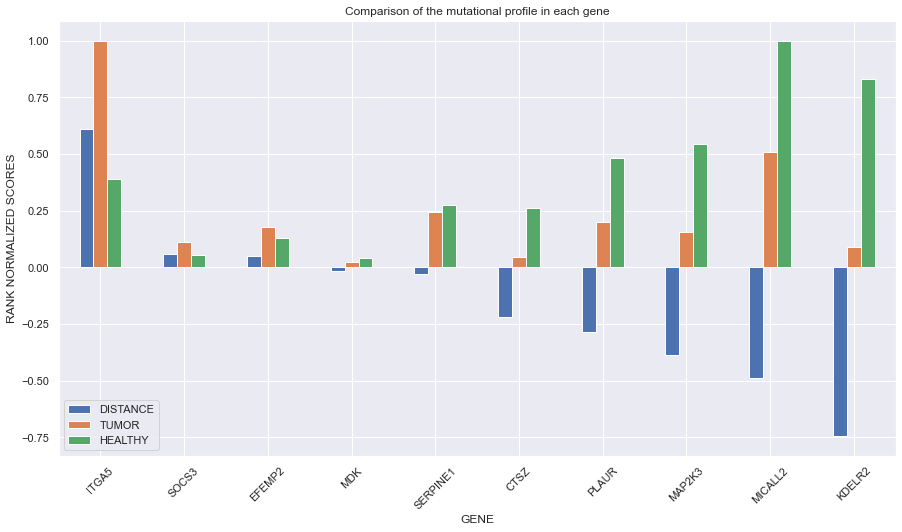

,GENE,SCORE_HEALTHY,DENSITY_HEALTHY,SCORE_TUMOR,DENSITY_TUMOR,DISTANCE
4,ITGA5,596,0.389542,45,1.000000,0.610458
8,SOCS3,83,0.054248,5,0.111111,0.056863
7,EFEMP2,197,0.128758,8,0.177778,0.049020
9,MDK,61,0.039869,1,0.022222,-0.017647
5,SERPINE1,421,0.275163,11,0.244444,-0.030719
6,CTSZ,403,0.263399,2,0.044444,-0.218954
3,PLAUR,740,0.483660,9,0.200000,-0.283660
2,MAP2K3,830,0.542484,7,0.155556,-0.386928
0,MICALL2,1530,1.000000,23,0.511111,-0.488889
1,KDELR2,1274,0.832680,4,0.088889,-0.743791


In [20]:
df4 = pd.merge(df3, df2, how='left', on=['GENE'], suffixes=('_HEALTHY', '_TUMOR'))
df4['DISTANCE'] = df4.apply(lambda r: r['DENSITY_TUMOR'] - r['DENSITY_HEALTHY'], axis=1)
df4.sort_values('DISTANCE', ascending=False, inplace=True)
# plot
df4_2 = df4.drop(['SCORE_HEALTHY', 'SCORE_TUMOR'], axis=1)
df4_2 = pd.pivot_table(df4_2, index='GENE').sort_values('DISTANCE', ascending=False)
df4_2 = df4_2[['DISTANCE', 'DENSITY_TUMOR', 'DENSITY_HEALTHY']]
df4_2.plot(
    kind='bar',
    figsize=(15, 8),
    legend=True
)
plt.title('Comparison of the mutational profile in each gene')
plt.ylabel('RANK NORMALIZED SCORES')
plt.xticks(rotation=45)
plt.legend(['DISTANCE', 'TUMOR', 'HEALTHY'], loc=3)
plt.show()
# table
df4

### The comparison of the germline variation and somatic mutation profiles shows that ITGA5 is likely to be functionally related to the growth of skin cutaneous mealnoma. 
By the way, the articles cited below reinforce this conclusion and the effectiveness of the method used to identify genes related to a particular tumor form.

References:
- Przytycki, P. F., & Singh, M. (2017). Differential analysis between somatic mutation and germline variation profiles reveals cancer-related genes. Genome medicine, 9(1), 79. https://doi.org/10.1186/s13073-017-0465-6
- Lee, Y. S., Lee, C. H., Bae, J. T., Nam, K. T., Moon, D. B., Hwang, O. K., ... & Hwang, D. Y. (2018). Inhibition of skin carcinogenesis by suppression of NF-κB dependent ITGAV and TIMP-1 expression in IL-32γ overexpressed condition. Journal of Experimental & Clinical Cancer Research, 37(1), 293.
- Kang, C. L., Qi, B., Cai, Q. Q., Fu, L. S., Yang, Y., Tang, C., ... & Wu, X. Z. (2019). LncRNA AY promotes hepatocellular carcinoma metastasis by stimulating ITGAV transcription. Theranostics, 9(15), 4421.